In [1]:
import functools

import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import upsetplot

from data_loading import load_annotated_gencode_tfs, load_human_tf_db

In [2]:
tfs = load_annotated_gencode_tfs()

reading from cache


In [3]:
print(len(tfs), 'TFs')

1635 TFs


In [4]:
n_iso = pd.Series({name: len(tf.isoforms) for name, tf in tfs.items()})
n_iso.head()

SKI       1
PRDM16    4
TP73      9
HES3      1
ZBTB48    1
dtype: int64

In [5]:
print(f'TF with most isoforms is {n_iso.idxmax()} with {n_iso.max()} isoforms')

TF with most isoforms is CREM with 25 isoforms


<ipython-input-6-8e936a5b3427>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  pctax.set_yticklabels([f'{y:.0f}%' for y in pctax.get_yticks()])


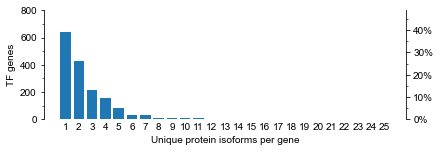

In [6]:
# add fraction axis on rhs
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=6, h=2)
xs = range(1, n_iso.max() + 1)
ax.bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])
ax.set_xticks(xs)
for pos in ['top', 'right', 'bottom']:
    ax.spines[pos].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel('Unique protein isoforms per gene')

def num2pct(y):
    return (y / n_iso.shape[0]) * 100

def pct2num(y):
    return (y / 100) * n_iso.shape[0]


ax.set_ylim(0, 800)
ax.set_yticks(range(0, 800, 100), minor=True)
ax.set_ylabel('TF genes')
for pos in ['top', 'right', 'bottom']:
    ax.spines[pos].set_visible(False)
pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
pctax.set_ylabel('')
pctax.set_yticks(range(0, 46, 5), minor=True)
pctax.set_yticklabels([f'{y:.0f}%' for y in pctax.get_yticks()])
fig.savefig('../figures/n-isoforms-per-gene_GENCODE-v30-TFs_hist.pdf',
            bbox_inches='tight')

In [7]:
# number of isoforms per family
df = pd.DataFrame([(tf.name, len(tf.isoforms), tf.tf_family) for name, tf in tfs.items()],
                  columns=['gene', 'n_isoforms', 'family'])
fam_size = df['family'].value_counts()
small_families = set(fam_size[fam_size < 20].index.values)
df['family_merged'] = df['family']
df.loc[df['family'].isin(small_families) | (df['family'] == 'Unknown'), 'family_merged'] = 'other'

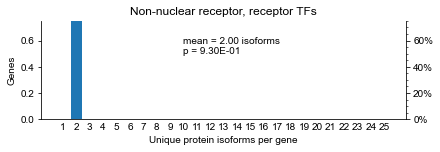

In [8]:
tfdb = load_human_tf_db()
non_nr_ligand_tfs = {'AHR'} # Hand-curated

fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(h=2, w=6)
xs = range(1, df['n_isoforms'].max() + 1)

def num2pct(y, total):
    return (y / total) * 100

def pct2num(y, total):
    return (y / 100) * total

n_iso = df.loc[df['gene'].isin(non_nr_ligand_tfs), 'n_isoforms']
ax.bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])
ax.set_title('Non-nuclear receptor, receptor TFs')
for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('Genes')

n = df['gene'].isin(non_nr_ligand_tfs).sum()
pctax = ax.secondary_yaxis('right', 
                            functions=(functools.partial(num2pct, total=n),
                                        functools.partial(pct2num, total=n)))
ax.set_ylim(0, 0.75 * n)
p = min(
    (stats.mannwhitneyu(df.loc[df['gene'].isin(non_nr_ligand_tfs), 'n_isoforms'].values,
                        df.loc[~df['gene'].isin(non_nr_ligand_tfs), 'n_isoforms'].values).pvalue
                        ),
                        1
                        )
ax.text(s=f'mean = {n_iso.mean():.2f} isoforms\np = {p:.2E}',
        x=10,
        y=0.5 * n)
pctax.set_yticks(range(0, 80, 20))
pctax.set_yticks(range(0, 80, 5), minor=True)
pctax.set_yticklabels([f'{y:.0f}%' for y in pctax.get_yticks()])

ax.set_xticks(xs)
ax.set_xlabel('Unique protein isoforms per gene')


fig.savefig('../figures/n-isoforms-per-gene_GENCODE-v30-non-NR-receptor-TFs_hist.pdf',
            bbox_inches='tight')

In [9]:
tfdb.loc[tfdb['DBD'] == 'Myb/SANT', :]

,Ensembl ID,HGNC symbol,DBD,Is TF?,TF assessment,Binding mode,Motif status,Final Notes,Final Comments,Interpro ID(s),EntrezGene ID,EntrezGene Description,PDB ID,TF tested by HT-SELEX?,TF tested by PBM?,Conditional Binding Requirements,Original Comments,Vaquerizas 2009 classification,CisBP considers it a TF?,TFCat classification,Is a GO TF?,Initial assessment,Curator 1,Curator 2,TFclass considers it a TF?,Go Evidence,Pfam Domains (By ENSP ID)
1540,ENSG00000096401,CDC5L,Myb/SANT,True,Known motif,Monomer or homomultimer,In vivo/Misc source,Only known motifs are from Transfac or HocoMoc...,Compelling evidence for DNA binding (PMID: 110...,IPR001005;IPR009057;IPR017930;IPR021786,988,cell division cycle 5 like [Source:HGNC Symbol...,NaN,DBD and Full,not tested,NaN,NaN,a,Yes,TF Evidence Conflict - There is evidence for a...,Yes,"2a1, Lower confidence direct evidence",Laura Campitelli,Matt Weirauch,Yes,$#ENSG00000096401#GO:0000981#sequence-specific...,$#ENSP00000360532#ENSG00000096401#ENST00000371...
1543,ENSG00000135164,DMTF1,Myb/SANT,True,Likely to be sequence specific TF,Monomer or homomultimer,No motif,NaN,Contains 2 Myb DBDs. Binds to CCCG(G/T)ATGT (P...,IPR001005;IPR009057;IPR017877;IPR017930,9988,cyclin D binding myb like transcription factor...,NaN,DBD and Full,not tested,NaN,NaN,a,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"3a, decent circumstantial evidence for its rol...",Pratyush Das,Arttu Jolma,Yes,$#ENSG00000135164#GO:0000981#sequence-specific...,$#ENSP00000332171#ENSG00000135164#ENST00000331...
1552,ENSG00000170903,MSANTD4,Myb/SANT,True,Likely to be sequence specific TF,Low specificity DNA-binding protein,No motif,NaN,Contains a single Myb-like domain with an inse...,IPR028002,84437,Myb/SANT DNA binding domain containing 4 with ...,NaN,not tested,not tested,NaN,NaN,No,Yes,No,No,"5a, one of the source datasets predicts is as ...",Yimeng Yin,Laura Campitelli,No,NaN,$#ENSP00000304713#ENSG00000170903#ENST00000301...
1553,ENSG00000118513,MYB,Myb/SANT,True,Known motif,Monomer or homomultimer,In vivo/Misc source,Only known motifs are from Transfac or HocoMoc...,Contains 3 Myb DBDs,IPR001005;IPR009057;IPR012642;IPR015395;IPR017...,4602,"MYB proto-oncogene, transcription factor [Sour...",1MSE,DBD and Full,Yes,NaN,NaN,a,Yes,TF Gene Candidate_DNA-Binding: sequence-specif...,Yes,"1a1, Direct HQ evidence",Yimeng Yin,Laura Campitelli,Yes,$#ENSG00000118513#GO:0000981#sequence-specific...,$#ENSP00000339992#ENSG00000118513#ENST00000341...
1554,ENSG00000185697,MYBL1,Myb/SANT,True,Known motif,Monomer or homomultimer,High-throughput in vitro,NaN,Contains 3 Myb DBDs,IPR001005;IPR009057;IPR012642;IPR015395;IPR017...,4603,MYB proto-oncogene like 1 [Source:HGNC Symbol;...,NaN,DBD and Full,Yes,NaN,NaN,a,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Laura Campitelli,Arttu Jolma,Yes,$#ENSG00000185697#GO:0001077#RNA polymerase II...,$#ENSP00000429633#ENSG00000185697#ENST00000522...
1555,ENSG00000101057,MYBL2,Myb/SANT,True,Known motif,Monomer or homomultimer,High-throughput in vitro,NaN,Contains 3 Myb DBDs,IPR001005;IPR009057;IPR015395;IPR017877;IPR017...,4605,MYB proto-oncogene like 2 [Source:HGNC Symbol;...,NaN,DBD and Full,Yes,NaN,NaN,a,Yes,TF Gene Candidate_DNA-Binding: sequence-specif...,Yes,"1a1, Direct HQ evidence",Matt Weirauch,Jussi Taipale,Yes,$#ENSG00000101057#GO:0001077#RNA polymerase II...,$#ENSP00000217026#ENSG00000101057#ENST00000217...
1556,ENSG00000176182,MYPOP,Myb/SANT,True,Likely to be sequence specific TF,Monomer or homomultimer,No motif,NaN,Contains a single Myb-like domain. Mouse ortho...,IPR001005;IPR017877;IPR028002;,339344,"Myb-related transcription factor, partner of p...",NaN,not tested,not tested,NaN,NaN,c,No,No,Yes,"1a1, Direct HQ evidence",Pratyush Das,Arttu Jolma,No,$#ENSG00000176182#GO:0001078#RNA polymerase II...,$#ENSP00000325402#ENSG00000176182#ENST00000322...
1557,ENSG00000162601,MYSM1,Myb/SANT,True,Likely to be sequence specific TF,Low specificity DNA-binding 

In [10]:
tfdb['DBD'].value_counts().tail(60)

Forkhead                   49
Nuclear receptor           46
HMG/Sox                    30
Ets                        27
T-box                      17
AT hook                    16
Homeodomain; POU           16
Myb/SANT                   14
THAP finger                12
E2F                        11
CENPB                      11
BED ZF                     10
GATA                       10
Rel                        10
CxxC                        9
IRF                         9
SMAD                        9
SAND                        9
RFX                         8
HSF                         8
MBD                         8
CUT; Homeodomain            7
DM                          7
STAT                        7
MADS box                    6
Grainyhead                  6
ARID/BRIGHT                 6
Homeodomain; Paired box     5
AP-2                        5
CSD                         5
GTF2I-like                  4
TEA                         4
EBF1                        4
C2H2 ZF; A

In [11]:
print(' '.join(non_nr_ligand_tfs))

AHR


In [12]:
tfdb.loc[tfdb['HGNC symbol'] == 'SREBF1']

,Ensembl ID,HGNC symbol,DBD,Is TF?,TF assessment,Binding mode,Motif status,Final Notes,Final Comments,Interpro ID(s),EntrezGene ID,EntrezGene Description,PDB ID,TF tested by HT-SELEX?,TF tested by PBM?,Conditional Binding Requirements,Original Comments,Vaquerizas 2009 classification,CisBP considers it a TF?,TFCat classification,Is a GO TF?,Initial assessment,Curator 1,Curator 2,TFclass considers it a TF?,Go Evidence,Pfam Domains (By ENSP ID)
138,ENSG00000072310,SREBF1,bHLH,True,Known motif,Monomer or homomultimer,High-throughput in vitro,NaN,NaN,IPR011598;,6720,sterol regulatory element binding transcriptio...,1AM9,DBD,Yes,NaN,Structure is homodimer with the non E-box site,a,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Jussi Taipale,Matt Weirauch,Yes,$#ENSG00000072310#GO:0001077#RNA polymerase II...,$#ENSP00000261646#ENSG00000072310#ENST00000261...


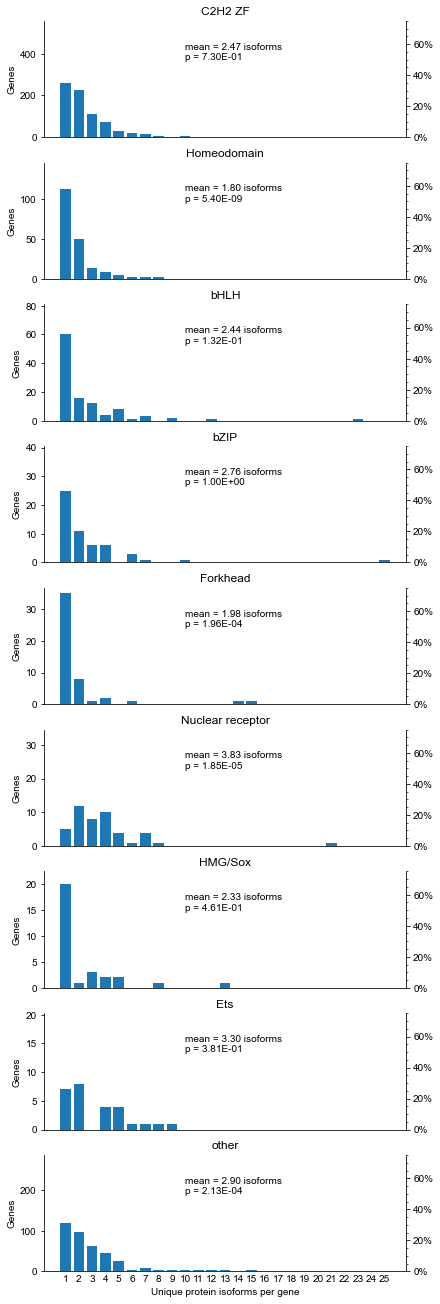

In [13]:
# p-value
# make look nice
families = list(df['family_merged'].value_counts().index.values)
families.remove('other')
families += ['other']

fig, axs = plt.subplots(len(families), 1, sharex=True)
fig.set_size_inches(h=2 * len(families), w=6)
xs = range(1, df['n_isoforms'].max() + 1)

def num2pct(y, total):
    return (y / total) * 100

def pct2num(y, total):
    return (y / 100) * total

for fam, ax in zip(families, axs):
    n_iso = df.loc[df['family_merged'] == fam, 'n_isoforms']
    ax.bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])
    ax.set_title(fam)
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    ax.set_ylabel('Genes')

    n = (df['family_merged'] == fam).sum()
    pctax = ax.secondary_yaxis('right', 
                               functions=(functools.partial(num2pct, total=n),
                                          functools.partial(pct2num, total=n)))
    ax.set_ylim(0, 0.75 * n)
    p = min(
        (stats.mannwhitneyu(df.loc[df['family_merged'] == fam, 'n_isoforms'].values,
                           df.loc[df['family_merged'] != fam, 'n_isoforms'].values).pvalue
                           * len(families)
                           ),
                           1
                           )
    ax.text(s=f'mean = {n_iso.mean():.2f} isoforms\np = {p:.2E}',
            x=10,
            y=0.5 * n)
    pctax.set_yticks(range(0, 80, 20))
    pctax.set_yticks(range(0, 80, 5), minor=True)
    pctax.set_yticklabels([f'{y:.0f}%' for y in pctax.get_yticks()])

axs[-1].set_xticks(xs)
axs[-1].set_xlabel('Unique protein isoforms per gene')


fig.savefig('../figures/n-isoforms-per-gene_GENCODE-v30-TFs_by-family_hist.pdf',
            bbox_inches='tight')

In [14]:
df['n_isoforms'].mean()

2.5345565749235472

In [15]:
(df['family_merged'] == 'Ets').sum()

27

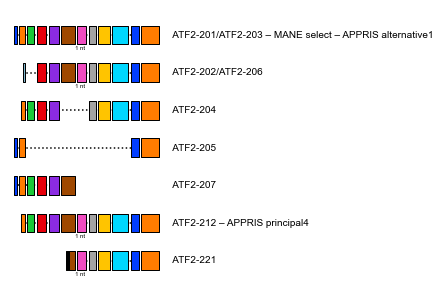

In [16]:
# types of splicing
# including matrix or venn or something...
tfs['ATF2'].exon_diagram()

In [17]:
tfs['ATF2'].isoforms[0]

Isoform: ATF2-201|ATF2-203 / ENSP00000264110|ENSP00000376327 / ENST00000264110|ENST00000392544
length: 505 aa

In [18]:
cats = pd.DataFrame([tf.splicing_categories(tf.MANE_select_isoform.name, alt_iso.name) 
              for tf in tfs.values()
              for alt_iso in tf.isoforms[1:]
              if tf.has_MANE_select_isoform
              and alt_iso != tf.MANE_select_isoform])

In [19]:
# check at least one of something

In [20]:
cats.mean()

<ipython-input-20-b63abeee1d7d>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  cats.mean()


alternative N-terminal        0.551370
alternative C-terminal        0.597260
alternative internal exon     0.242466
alternative 5' splice site    0.382877
alternative 3' splice site    0.471233
exon skipping                 0.189041
mutually exclusive exons      0.013014
intron retention              0.038356
dtype: float64

In [21]:
cats.head()

,gene,reference isoform,alternative isoform,alternative N-terminal,alternative C-terminal,alternative internal exon,alternative 5' splice site,alternative 3' splice site,exon skipping,mutually exclusive exons,intron retention
0,PRDM16,PRDM16-201,PRDM16-206,False,True,True,True,True,True,False,False
1,PRDM16,PRDM16-201,PRDM16-208,False,True,True,True,True,True,False,False
2,TP73,TP73-208,TP73-202,False,True,True,True,False,True,False,False
3,TP73,TP73-208,TP73-204,True,True,True,True,False,True,False,False
4,TP73,TP73-208,TP73-205,True,True,True,True,False,True,False,False


In [22]:
cats.loc[cats['intron retention']].head()

,gene,reference isoform,alternative isoform,alternative N-terminal,alternative C-terminal,alternative internal exon,alternative 5' splice site,alternative 3' splice site,exon skipping,mutually exclusive exons,intron retention
107,FOXN2,FOXN2-201,FOXN2-203,True,False,False,True,True,False,False,True
160,ZC3H8,ZC3H8-201,ZC3H8-208,False,True,False,True,True,False,False,True
166,ZEB2,ZEB2-204,ZEB2-210,True,True,True,True,True,False,False,True
169,ZEB2,ZEB2-204,ZEB2-232,False,True,False,True,True,False,False,True
172,NR4A2,NR4A2-201,NR4A2-203,False,True,False,True,True,False,False,True


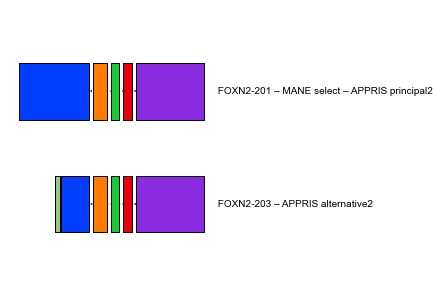

In [23]:
# DEBUG
tfs['FOXN2'].exon_diagram()

In [24]:
cat_cols = cats.columns[3:]
n_cats = cats[cat_cols].sum(axis=1).value_counts().sort_index()
n_cats

1    304
2    587
3    237
4    240
5     72
6     20
dtype: int64

In [25]:
n_cats / n_cats.sum() * 100

1    20.821918
2    40.205479
3    16.232877
4    16.438356
5     4.931507
6     1.369863
dtype: float64

In [26]:
#DEBUG
cats.head()

,gene,reference isoform,alternative isoform,alternative N-terminal,alternative C-terminal,alternative internal exon,alternative 5' splice site,alternative 3' splice site,exon skipping,mutually exclusive exons,intron retention
0,PRDM16,PRDM16-201,PRDM16-206,False,True,True,True,True,True,False,False
1,PRDM16,PRDM16-201,PRDM16-208,False,True,True,True,True,True,False,False
2,TP73,TP73-208,TP73-202,False,True,True,True,False,True,False,False
3,TP73,TP73-208,TP73-204,True,True,True,True,False,True,False,False
4,TP73,TP73-208,TP73-205,True,True,True,True,False,True,False,False


<ipython-input-27-7029738ef09e>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (cats.mean() * 100).plot.bar(ax=ax)


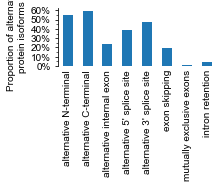

In [27]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(h=2.5, w=3)
(cats.mean() * 100).plot.bar(ax=ax)
ax.set_ylabel('Proportion of alternative\nprotein isoforms')
for pos in ['top', 'right', 'bottom']:
    ax.spines[pos].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_yticks(range(0, 61, 10))
ax.set_yticklabels(f'{y:d}%' for y in ax.get_yticks())
ax.set_yticks(range(0, int(ax.get_ylim()[1]), 5),
              minor=True)
fig.savefig('../figures/splice-categories_TFs-in-GENCODE-v30_bar.pdf',
            bbox_inches='tight')

<ipython-input-28-7ccb3f077c21>:2: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('../figures/isoform-categories_gencode_UpSet-plot.pdf',
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


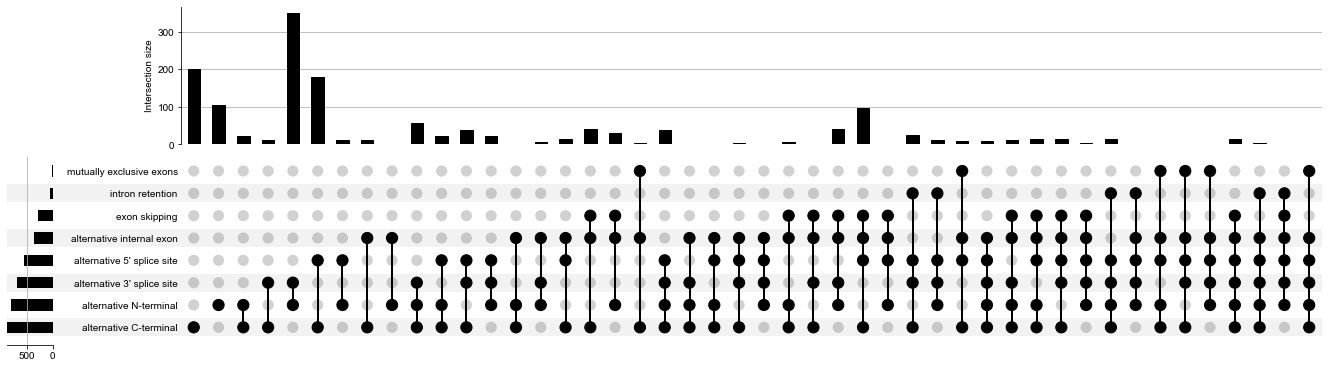

In [28]:
upsetplot.plot(cats.groupby(list(cat_cols)).size())
plt.savefig('../figures/isoform-categories_gencode_UpSet-plot.pdf',
            bbox_inches='tight')

In [29]:
from data_loading import load_annotated_6k_collection

tfs_cloned = load_annotated_6k_collection()

reading from cache


In [30]:
df['n_isoforms_cloned'] = (df['gene'].map({tf.name: len(tf.isoforms) for tf in tfs_cloned.values()})
                            .fillna(0)
                            .astype(int))

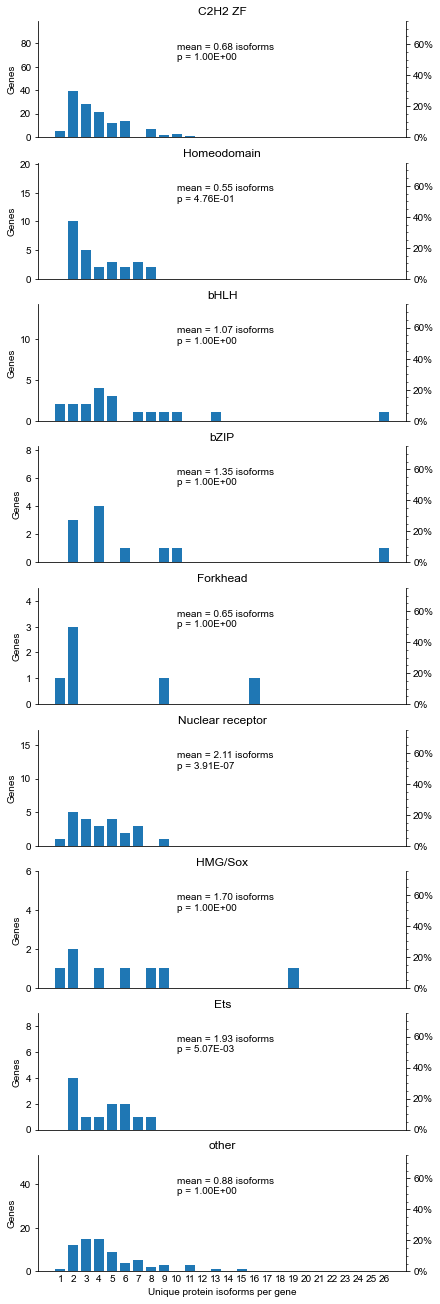

In [31]:
# p-value
# make look nice
families = list(df['family_merged'].value_counts().index.values)
families.remove('other')
families += ['other']

fig, axs = plt.subplots(len(families), 1, sharex=True)
fig.set_size_inches(h=2 * len(families), w=6)
xs = range(1, df['n_isoforms_cloned'].max() + 1)

def num2pct(y, total):
    return (y / total) * 100

def pct2num(y, total):
    return (y / 100) * total

for fam, ax in zip(families, axs):
    n_iso = df.loc[df['family_merged'] == fam, 'n_isoforms_cloned']
    ax.bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])
    ax.set_title(fam)
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    ax.set_ylabel('Genes')

    n = (df.loc[df['n_isoforms_cloned'] >= 1, 'family_merged'] == fam).sum()
    pctax = ax.secondary_yaxis('right', 
                               functions=(functools.partial(num2pct, total=n),
                                          functools.partial(pct2num, total=n)))
    ax.set_ylim(0, 0.75 * n)
    p = min(
        (stats.mannwhitneyu(df.loc[df['family_merged'] == fam, 'n_isoforms_cloned'].values,
                           df.loc[df['family_merged'] != fam, 'n_isoforms_cloned'].values).pvalue
                           * len(families)
                           ),
                           1
                           )
    ax.text(s=f'mean = {n_iso.mean():.2f} isoforms\np = {p:.2E}',
            x=10,
            y=0.5 * n)
    pctax.set_yticks(range(0, 80, 20))
    pctax.set_yticks(range(0, 80, 5), minor=True)
    pctax.set_yticklabels([f'{y:.0f}%' for y in pctax.get_yticks()])

axs[-1].set_xticks(xs)
axs[-1].set_xlabel('Unique protein isoforms per gene')


fig.savefig('../figures/n-isoforms-per-gene_TFiso1-TFs_by-family_hist.pdf',
            bbox_inches='tight')

<ipython-input-32-dbd2071518d3>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  pctax.set_yticklabels([f'{y:.0f}%' for y in pctax.get_yticks()])


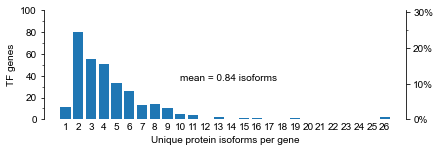

In [32]:
# add fraction axis on rhs
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=6, h=2)
xs = range(1, df['n_isoforms_cloned'].max() + 1)
ax.bar(x=xs, height=[df['n_isoforms_cloned'].value_counts().to_dict().get(x, 0) for x in xs])
ax.set_xticks(xs)
for pos in ['top', 'right', 'bottom']:
    ax.spines[pos].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel('Unique protein isoforms per gene')

def num2pct(y):
    return (y / df['n_isoforms_cloned'].shape[0]) * 100

def pct2num(y):
    return (y / 100) * df['n_isoforms_cloned'].shape[0]


ax.text(s=f'mean = {df["n_isoforms_cloned"].mean():.2f} isoforms',
        x=10,
        y=0.5 * n)

ax.set_ylim(0, 100)
ax.set_yticks(range(0, 100, 10), minor=True)
ax.set_ylabel('TF genes')
for pos in ['top', 'right', 'bottom']:
    ax.spines[pos].set_visible(False)
pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
pctax.set_ylabel('')
pctax.set_yticks(range(0, 46, 5), minor=True)
pctax.set_yticklabels([f'{y:.0f}%' for y in pctax.get_yticks()])
fig.savefig('../figures/n-isoforms-per-gene_TFiso1-TFs_hist.pdf',
            bbox_inches='tight')